In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
pd.set_option("display.max_rows", 1000)    #設定最大能顯示1000rows
pd.set_option("display.max_columns", 1000)   #設定最大能顯示1000columns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder       #轉字串為數字
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix


In [3]:
train_link = '/kaggle/input/siim-isic-melanoma-classification/train.csv'
train_df = pd.read_csv(train_link)
test_link = '/kaggle/input/siim-isic-melanoma-classification/test.csv'
test_df = pd.read_csv(test_link)

new_names = ['dcm_name', 'ID', 'sex', 'age', 'body_part', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

print(train_df.head())
print(test_df.head())

       dcm_name          ID     sex   age        body_part diagnosis  \
0  ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0  
       dcm_name          ID     sex   age        body_part
0  ISIC_0052060  IP_3579794    male  70.0              NaN
1  ISIC_0052349  IP_7782715    male  40.0  lower extremity
2  ISIC_0058510  IP_7960270  female  55.0            torso
3  ISIC_0073313  IP_6375035  female  50.0            torso
4  ISIC_0073502  IP_0589375  female  45.0  lower extremity


In [4]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

train_df['age'] = train_df['age'].fillna(train_df['age'].median())            # age補缺失值: 平均
train_df['sex'] = train_df['sex'].fillna('no')                                # sex補缺失值: no
train_df['body_part'] = train_df['body_part'].fillna('no')                    #body_part補缺失值: no

test_df['body_part'] = test_df['body_part'].fillna('no')                    #body_part補缺失值: no

dcm_name              0
ID                    0
sex                  65
age                  68
body_part           527
diagnosis             0
benign_malignant      0
target                0
dtype: int64
dcm_name       0
ID             0
sex            0
age            0
body_part    351
dtype: int64


In [5]:
train_df['target'] = train_df['target'].astype('int64')     
train_df.dtypes

dcm_name             object
ID                   object
sex                  object
age                 float64
body_part            object
diagnosis            object
benign_malignant     object
target                int64
dtype: object

In [6]:
numaaa = 0 

def TheWhole(name='', num = 0.0) : 
  for i in range(len(train_df)) : 
    if train_df[name][i] == 1 : 
       num = num + 1.0
    i = i + 1 
     
  print(name,': ',num)

TheWhole('target', numaaa) 

target :  584.0


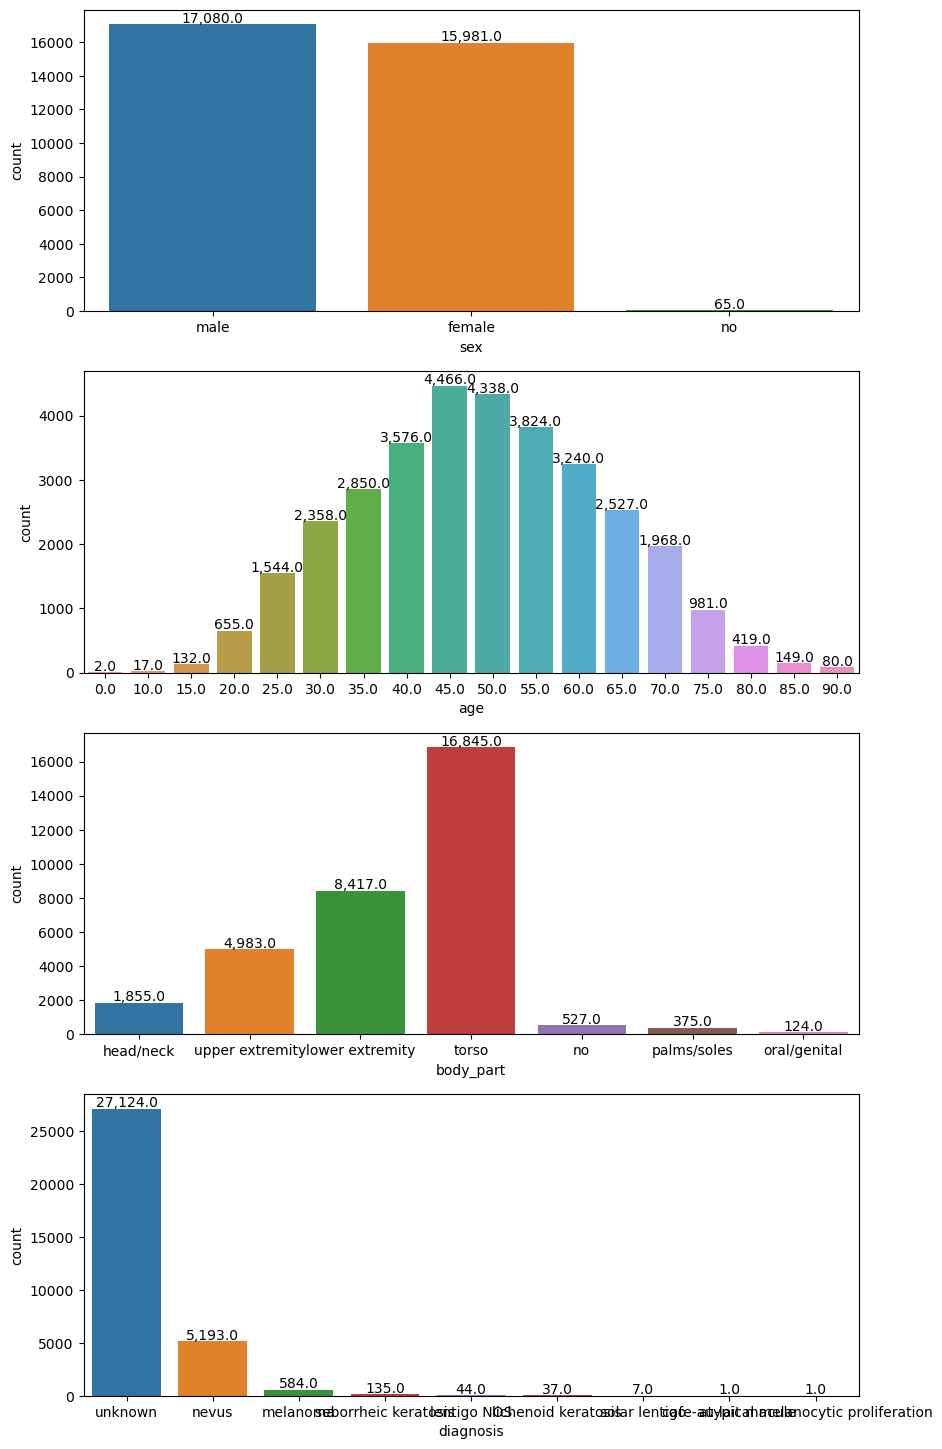

In [7]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,18))          # 特徵視覺化
a = sns.countplot(x='sex', data=train_df, ax=ax1)
b = sns.countplot(x='age', data=train_df, ax=ax2)
c = sns.countplot(x='body_part', data=train_df, ax=ax3)
d = sns.countplot(x='diagnosis', data=train_df, ax=ax4)

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
pic_name(c)
pic_name(d)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.path while we load stuff.


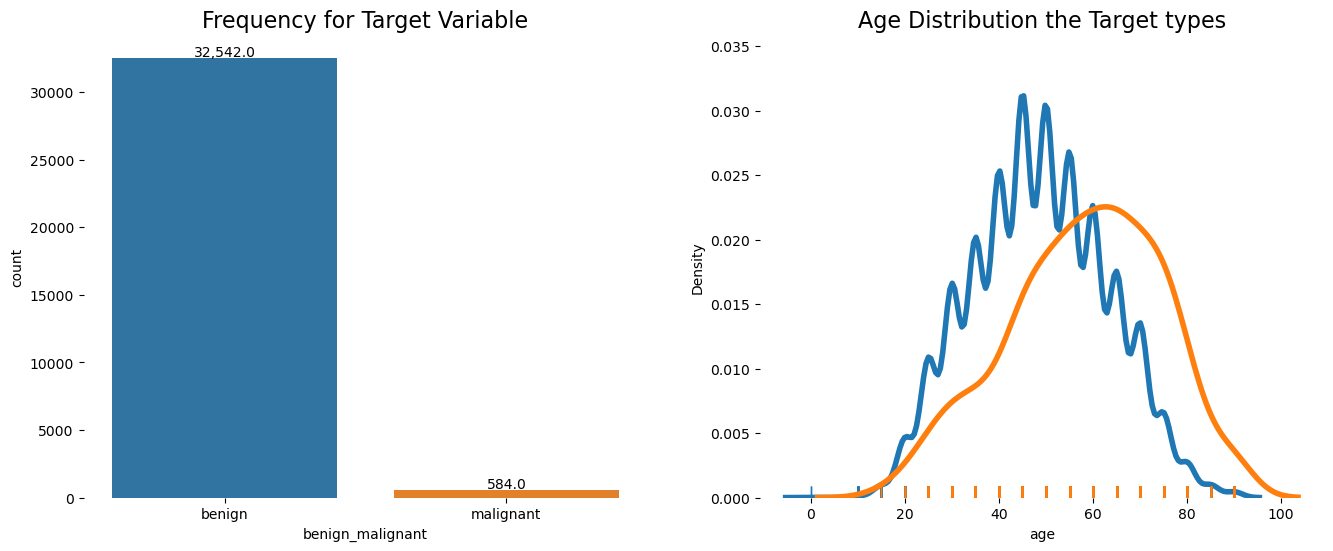

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

#描繪benign_malignant的直方圖
a = sns.countplot(data = train_df, x = 'benign_malignant', ax=ax1)
#描繪target=0的曲線
b = sns.distplot(a = train_df[train_df['target']==0]['age'], ax=ax2,
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
#描繪target=1的曲線
c = sns.distplot(a = train_df[train_df['target']==1]['age'], ax=ax2, 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
#標題名稱
ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);

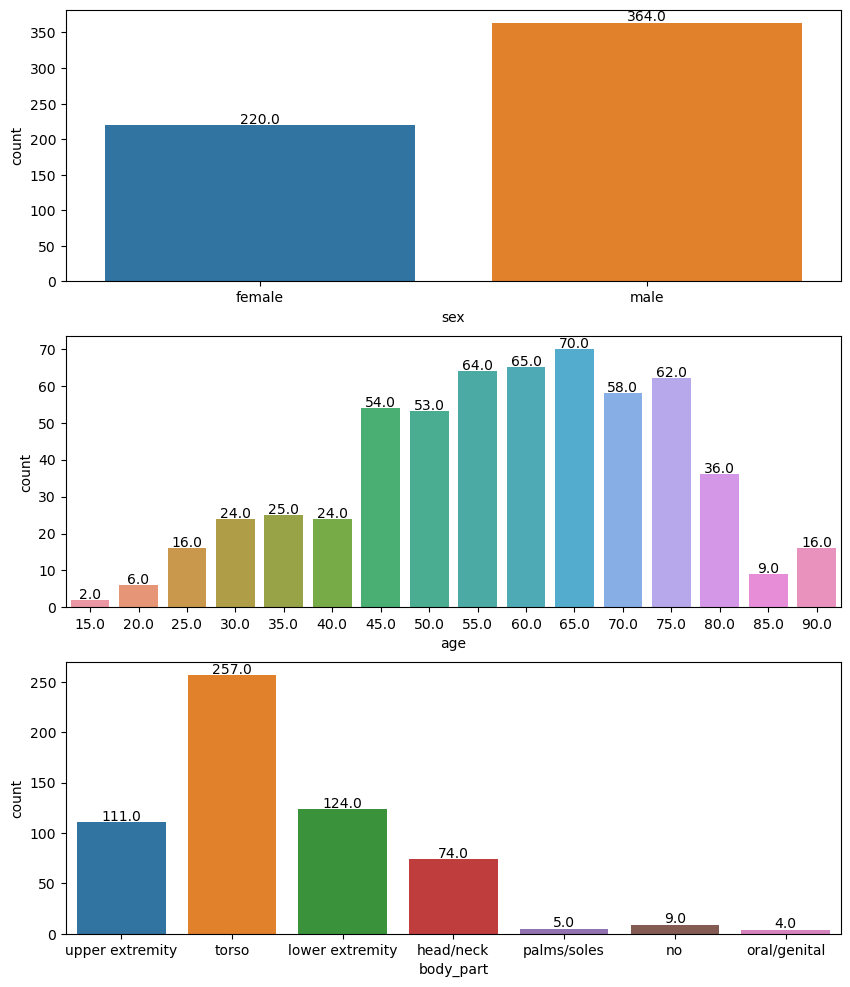

In [9]:
male_df = train_df[train_df['target'] == 1]   #只列出惡性的dataframe

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,12))          # 惡性特徵視覺化
a = sns.countplot(x='sex', data=male_df, ax=ax1)
b = sns.countplot(x='age', data=male_df, ax=ax2)
c = sns.countplot(x='body_part', data=male_df, ax=ax3)

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
pic_name(c)

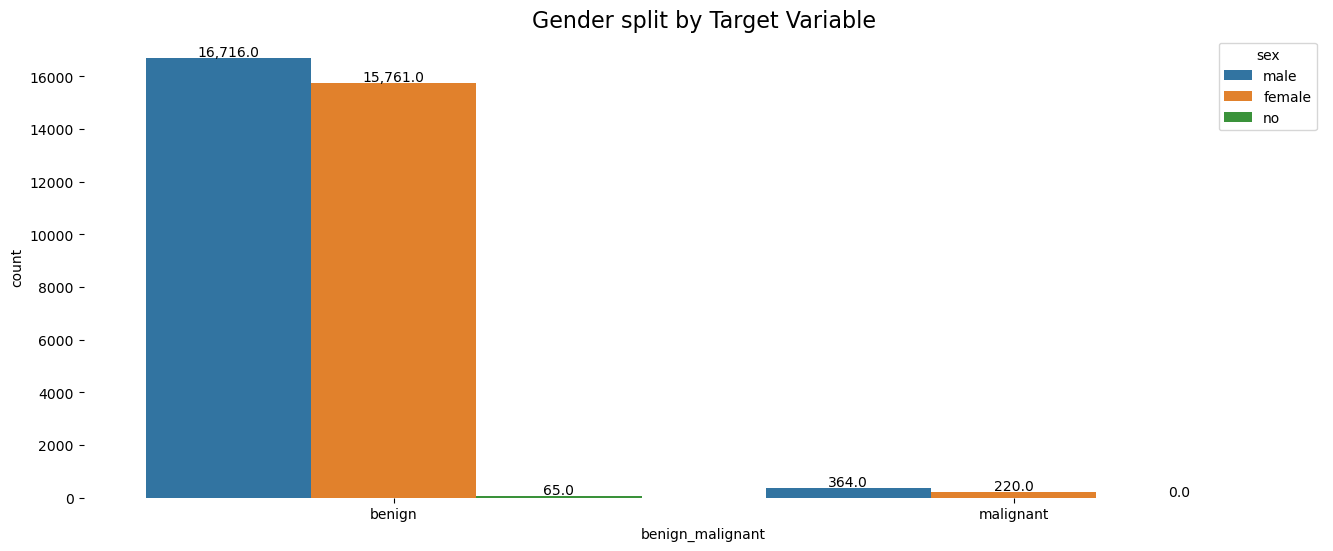

In [10]:
#繪製良性男女數量分布 & 惡性男女數量分布

plt.figure(figsize=(16, 6))
a = sns.countplot(data=train_df, x='benign_malignant', hue='sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  import sys


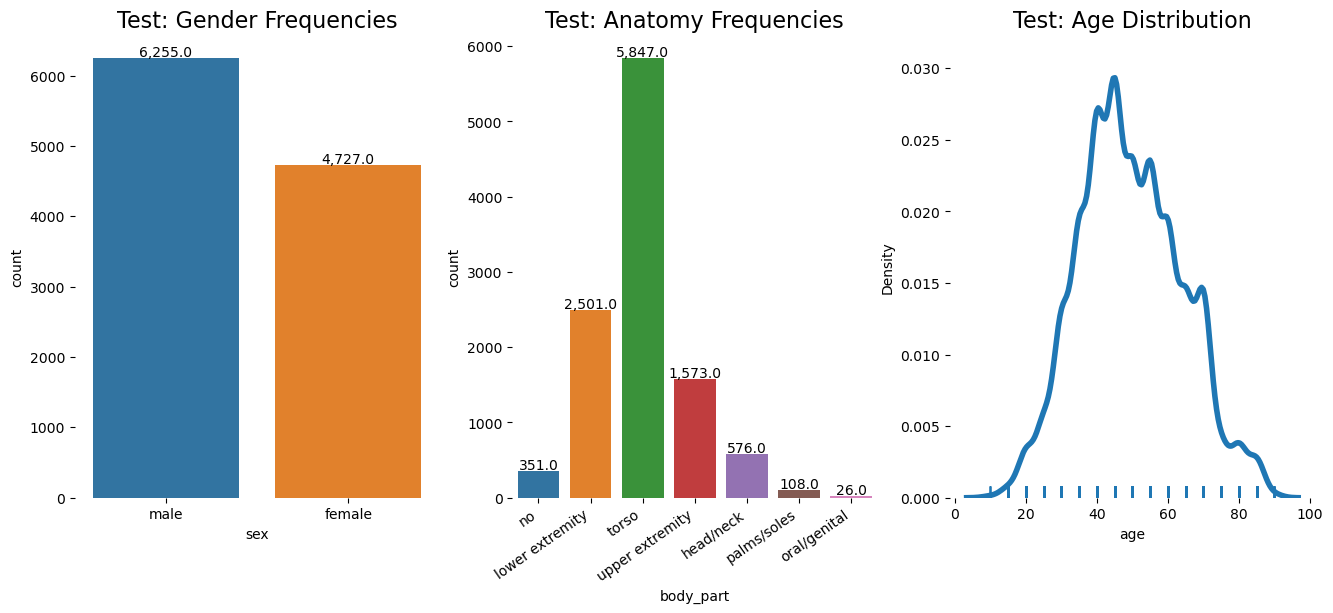

In [56]:
# Testdata測試集的特徵統計圖

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 6))

a = sns.countplot(x='sex', data = test_df, ax=ax1)
b = sns.countplot(x='body_part', data = test_df, ax=ax2)

c = sns.distplot(a = test_df['age'], ax=ax3, hist=False, rug=True, kde_kws=dict(linewidth=4))

def pic_name(haha):
    for p in haha.patches:
        haha.annotate(format(p.get_height(), ','), 
               (p.get_x() + p.get_width() / 2., 
                p.get_height()), ha = 'center', va = 'center', 
               xytext = (0, 4), textcoords = 'offset points')
pic_name(a)
pic_name(b)
    
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

In [49]:
train_x = train_df.drop(columns = ['target','dcm_name','ID','benign_malignant'])
train_y = train_df[["target"]]

#X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size = 0.25, random_state = 42)# 劃分訓練集，測試集

print(train_x)
print(train_y)

       sex   age  body_part  diagnosis
0        1  45.0          0          8
1        0  45.0          6          8
2        0  50.0          1          5
3        0  45.0          0          8
4        0  55.0          6          8
...    ...   ...        ...        ...
33121    1  50.0          5          8
33122    1  65.0          5          8
33123    1  20.0          1          8
33124    1  50.0          1          8
33125    1  45.0          5          5

[33126 rows x 4 columns]
       target
0           0
1           0
2           0
3           0
4           0
...       ...
33121       0
33122       0
33123       0
33124       0
33125       0

[33126 rows x 1 columns]


In [55]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

from sklearn.tree import plot_tree

model0 = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes = 10 )   # Entropy node Decision tree

scores = cross_val_score(model0, train_x, train_y, cv = kfold)

scores


array([1., 1., 1., 1., 1.])

In [56]:
from sklearn.tree import plot_tree

model0 = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes = 6 )   # Entropy node Decision tree
model0.fit(X_train, Y_train)
yyyyy = model0.predict(X_test)

print("正確率為", metrics.accuracy_score(Y_test, yyyyy))  
print('recall:',metrics.recall_score(Y_test, yyyyy))
print('precision:',metrics.precision_score(Y_test,yyyyy))
print('f1_score:',metrics.f1_score(Y_test, yyyyy))
print(confusion_matrix(Y_test, yyyyy))


正確率為 1.0
recall: 1.0
precision: 1.0
f1_score: 1.0
[[8132    0]
 [   0  150]]


           dcm_name          ID  sex   age  body_part  diagnosis  \
0      ISIC_2637011  IP_7279968    1  45.0          0          8   
1      ISIC_0015719  IP_3075186    0  45.0          6          8   
2      ISIC_0052212  IP_2842074    0  50.0          1          5   
3      ISIC_0068279  IP_6890425    0  45.0          0          8   
4      ISIC_0074268  IP_8723313    0  55.0          6          8   
...             ...         ...  ...   ...        ...        ...   
33121  ISIC_9999134  IP_6526534    1  50.0          5          8   
33122  ISIC_9999320  IP_3650745    1  65.0          5          8   
33123  ISIC_9999515  IP_2026598    1  20.0          1          8   
33124  ISIC_9999666  IP_7702038    1  50.0          1          8   
33125  ISIC_9999806  IP_0046310    1  45.0          5          5   

       benign_malignant target  
0                     0      0  
1                     0      0  
2                     0      0  
3                     0      0  
4                 

[Text(0.6, 0.8333333333333334, 'X[3] <= 4.5\nentropy = 0.127\nsamples = 24844\nvalue = [24410, 434]\nclass = t'),
 Text(0.4, 0.5, 'X[3] <= 3.5\nentropy = 0.534\nsamples = 494\nvalue = [60, 434]\nclass = a'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 60\nvalue = [60, 0]\nclass = t'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 434\nvalue = [0, 434]\nclass = a'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 24350\nvalue = [24350, 0]\nclass = t')]

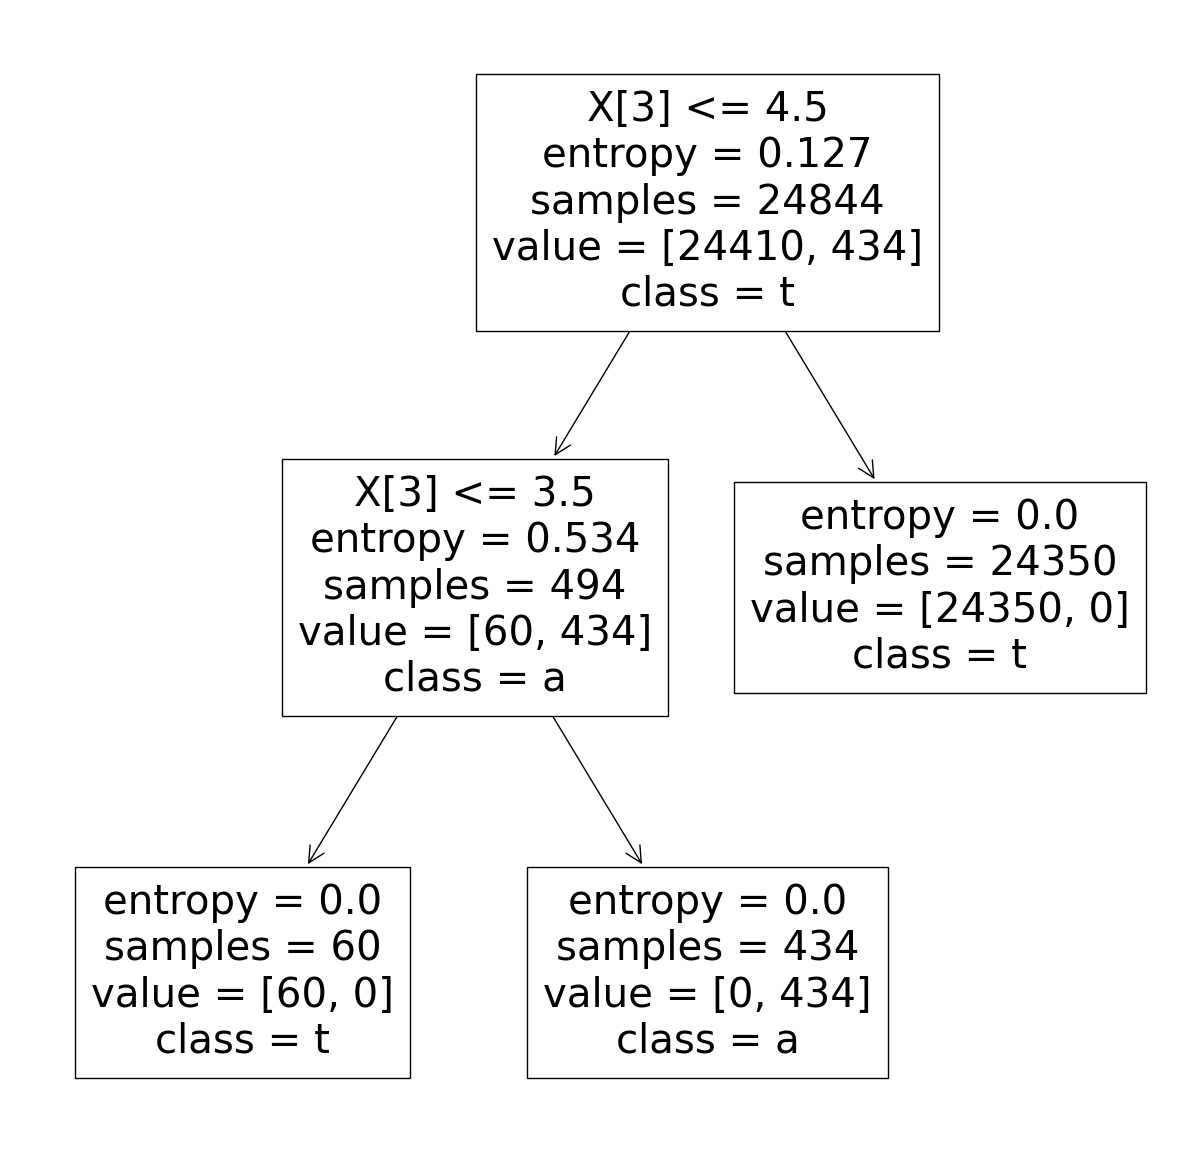